## OBJECTIVE :

### Predicting text emotions

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import sent_tokenize, word_tokenize

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.1
Pandas Version :  1.0.1
Matplotlib Version :  3.1.3


In [3]:
# Initializing spacy model
nlp = spacy.load('en_core_web_md')

In [4]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [5]:
LUCKY_SEED = 42

In [6]:
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_data")

In [7]:
STOPWORDS = nlp.Defaults.stop_words.union(STOPWORDS)
KEEPWORDS = ['up', 'down', 'no', 'not', 'nothing', 'none', 'neither', 'never', 'except', 'below', 'bottom', 'without', 'serious', \
            'really', 'above', 'against', 'cannot', 'least', 'less', 'more', 'most', 'must', 'top', 'well']
# for word in KEEPWORDS:
#     STOPWORDS.remove(word)
STOPWORDS = list(STOPWORDS)
DATE_STOPWORDS = ['january', 'february', 'march', 'april', 'may', 'june', \
                  'july', 'august', 'september', 'october', 'november', 'december', \
                 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', \
                 'today', 'tomorrow', 'yesterday', 'year', 'month', 'date', 'day']
NUM_STOPWORDS = ['hundred', 'hundreds', 'thousand', 'thousands', 'million', 'millions', 'billion', 'billions']
REL_STOPWORDS = ['brother', 'sister', 'son', 'daughter', 'father', 'mother', 'uncle', 'aunt', 'aunty', 'wife', \
                 'husband', 'cousin', 'nephew', 'niece', 'child', 'dad', 'mom', 'papa', 'mummy', 'bro', 'sis', \
                 'grandfather', 'grandmother', 'granny', 'grandpa', 'grandma', 'children', 'boy', 'boys', 'guy', \
                 'guys', 'girl', 'girls', 'man', 'men', 'woman', 'women']
DIR_STOPWORDS = ['north', 'south', 'east', 'west']
STOPWORDS += DATE_STOPWORDS + NUM_STOPWORDS + REL_STOPWORDS + DIR_STOPWORDS
STOPWORDS = set(STOPWORDS)
print(len(STOPWORDS))

459


In [14]:
# Read train data
train_data = pd.read_csv(os.path.join(RAW_DATA_DIR, "raw_train_data.csv"))

In [15]:
train_data.shape

(28648, 2)

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28648 entries, 0 to 28647
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  28648 non-null  object
 1   content    28648 non-null  object
dtypes: object(2)
memory usage: 447.8+ KB


In [17]:
train_data.head()

sentiment                                            content
0    neutral                            @kimdub I'm learning to
1  happiness  @Somong_MGMT We need 2 bust up the elites in D...
2     relief  @jessicacolon My son is back at school today -...
3   surprise                       @BKMS4life thx for following
4      anger  Some moving clips on youtube tonight of the vi...

In [22]:
# Read val data
val_data = pd.read_csv(os.path.join(RAW_DATA_DIR, "raw_val_data.csv"))
print("Shape of val data : {}".format(val_data.shape))
print()
print("Features in val_data : {}".format(val_data.columns.values))
print()
print("Val Dataframe Information : ")
print(val_data.info())
print()
print("Values proportions in sentiment column : ")
print(val_data["sentiment"].value_counts() / val_data.shape[0])

Shape of val data : (7162, 2)

Features in val_data : ['sentiment' 'content']

Val Dataframe Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7162 entries, 0 to 7161
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  7162 non-null   object
 1   content    7162 non-null   object
dtypes: object(2)
memory usage: 112.0+ KB
None

Values proportions in sentiment column : 
worry         0.207065
neutral       0.176766
sadness       0.168249
happiness     0.121614
love          0.057526
fear          0.052499
surprise      0.044960
anger         0.042167
hate          0.033091
fun           0.030438
relief        0.028484
empty         0.018291
enthusiasm    0.014521
boredom       0.004328
Name: sentiment, dtype: float64


In [18]:
# Read test data
test_data_kaggle = pd.read_csv(os.path.join(RAW_DATA_DIR, "raw_test_data_kaggle.csv"))
test_data_others = pd.read_csv(os.path.join(RAW_DATA_DIR, "raw_test_data_others.csv"))
print("Shape of kaggle test data : {}".format(test_data_kaggle.shape))
print("Shape of others test data : {}".format(test_data_others.shape))
print()
print("Features in kaggle test data : {}".format(test_data_kaggle.columns.values))
print("Features in others test data : {}".format(test_data_others.columns.values))
print()
print("Kaggle Test Dataframe Information : ")
print(test_data_kaggle.info())
print()
print("Others Test Dataframe Information : ")
print(test_data_others.info())

Shape of kaggle test data : (10000, 2)
Shape of others test data : (1037, 2)

Features in kaggle test data : ['id' 'content']
Features in others test data : ['content' 'sentiment']

Kaggle Test Dataframe Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       10000 non-null  int64 
 1   content  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Others Test Dataframe Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    1037 non-null   object
 1   sentiment  1037 non-null   object
dtypes: object(2)
memory usage: 16.3+ KB
None


#### Analysis of training data

In [23]:
train_data.drop_duplicates(subset="content").shape, train_data.shape, train_data.drop_duplicates().shape

((28648, 2), (28648, 2), (28648, 2))

In [24]:
train_data["sentiment"].value_counts() / train_data.shape[0]

worry         0.207135
neutral       0.176696
sadness       0.168284
happiness     0.121544
love          0.057596
fear          0.052395
surprise      0.044890
anger         0.042167
hate          0.033161
fun           0.030369
relief        0.028484
empty         0.018326
enthusiasm    0.014556
boredom       0.004398
Name: sentiment, dtype: float64

Different types of emotions and their counts : 


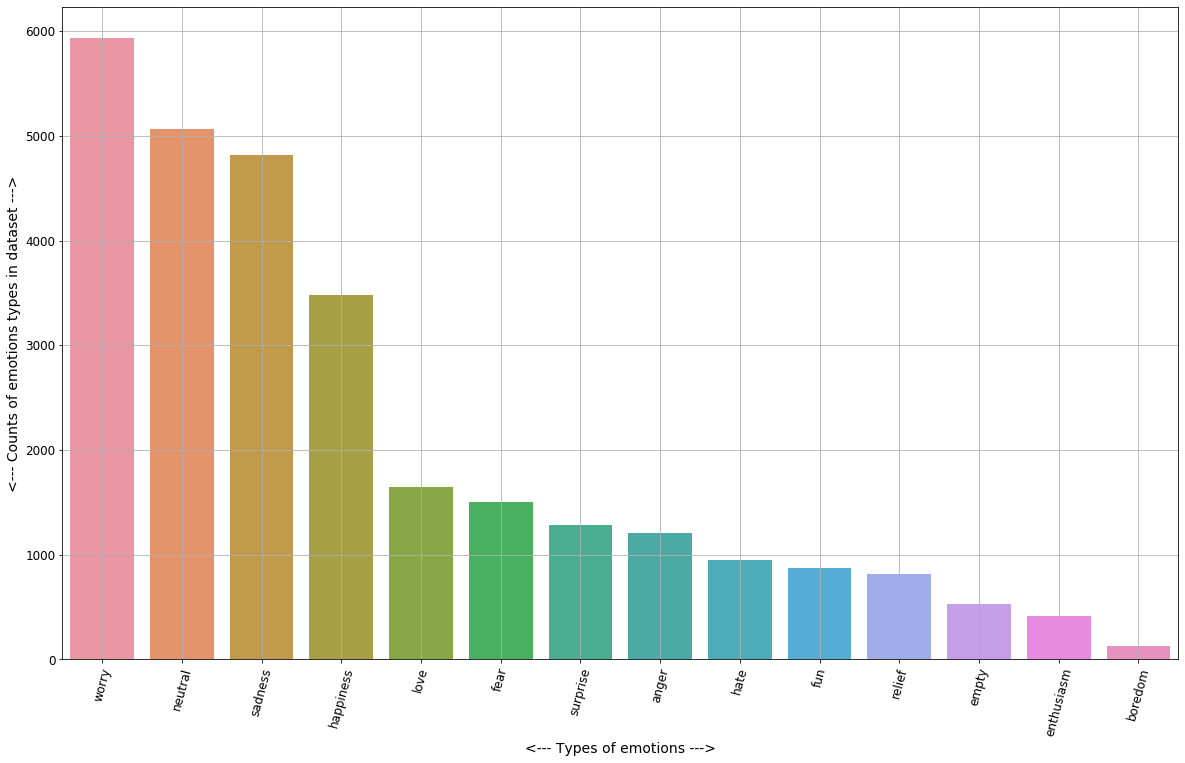

In [25]:
print('Different types of emotions and their counts : ')
fig_dims = (20, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(train_data['sentiment'].value_counts().index, train_data['sentiment'].value_counts().values)
plt.xticks(rotation=75)
plt.grid()
plt.xlabel('<--- Types of emotions --->')
plt.ylabel('<--- Counts of emotions types in dataset --->')
plt.show()

In [26]:
train_data["lcased_text"] = train_data["content"].map(lambda x:x.lower())

In [27]:
def create_wordcloud(sentences, label):
    print("Target Type : ", label)
    fig_dims = (20, 12)
    text = ' '.join(sentences) 
    wordcloud = WordCloud(stopwords=STOPWORDS, max_words=200, background_color="white").generate(text)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def get_word_count(text):
    word_count = 0
    sentences = sent_tokenize(text)
    for sen in sentences:
        word_count += len(word_tokenize(sen))
    return word_count

In [28]:
train_data["word_count"] = train_data["lcased_text"].map(get_word_count)

Target Type :  Worry Tweets


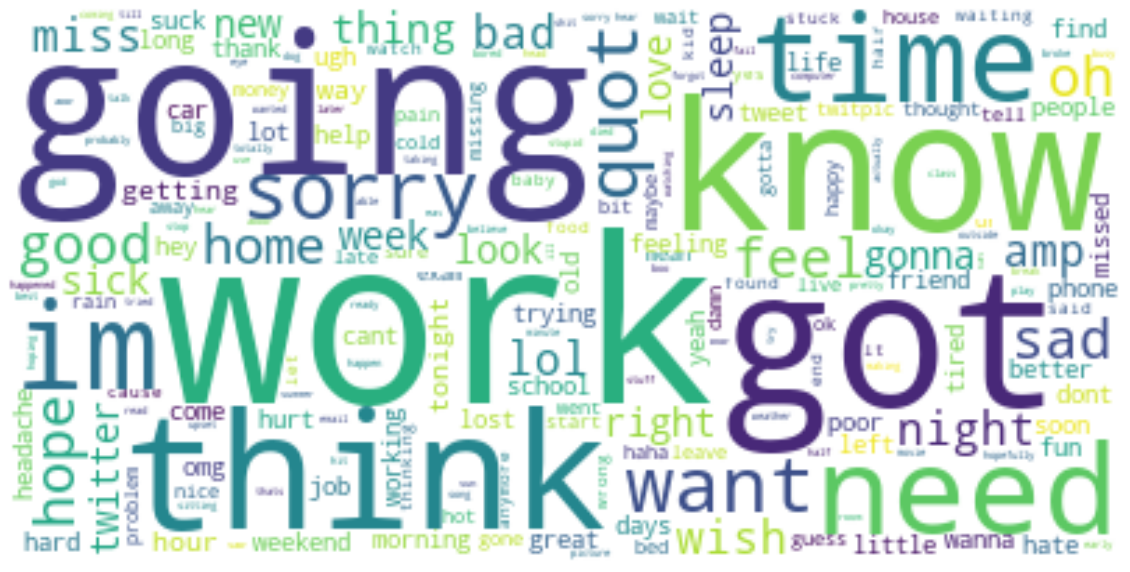

In [29]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="worry", "lcased_text"].values, "Worry Tweets")

Target Type :  Neutral Tweets


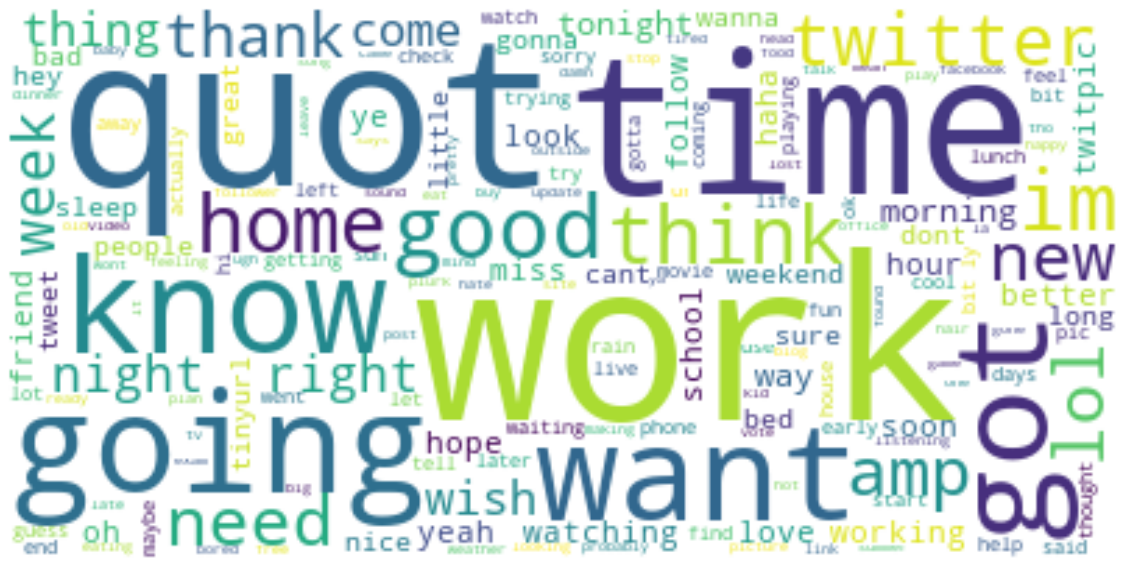

In [30]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="neutral", "lcased_text"].values, "Neutral Tweets")

Target Type :  Sadness Tweets


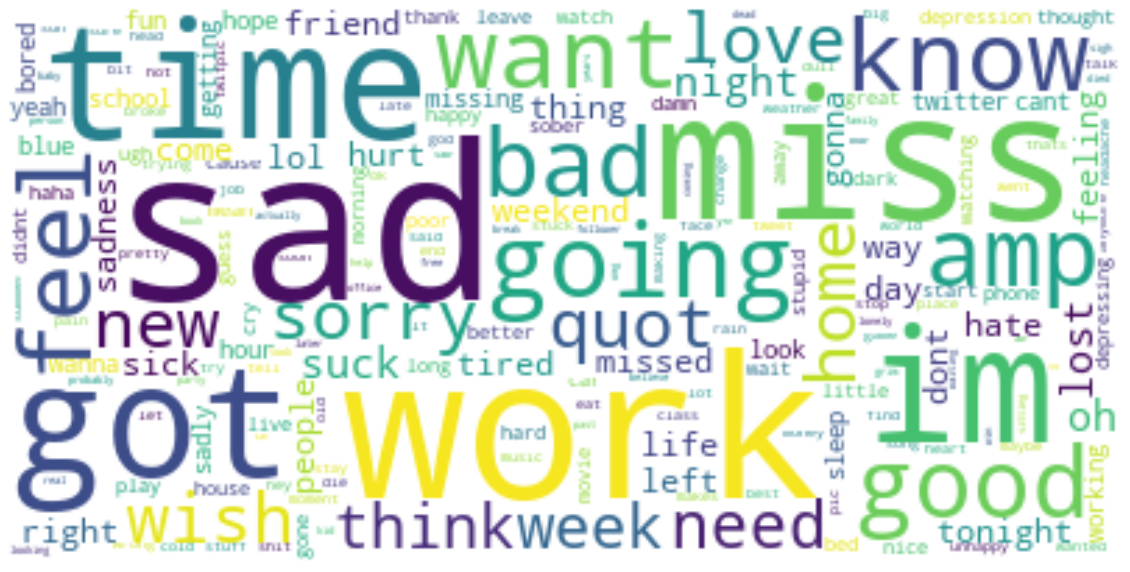

In [31]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="sadness", "lcased_text"].values, "Sadness Tweets")

Target Type :  Happiness Tweets


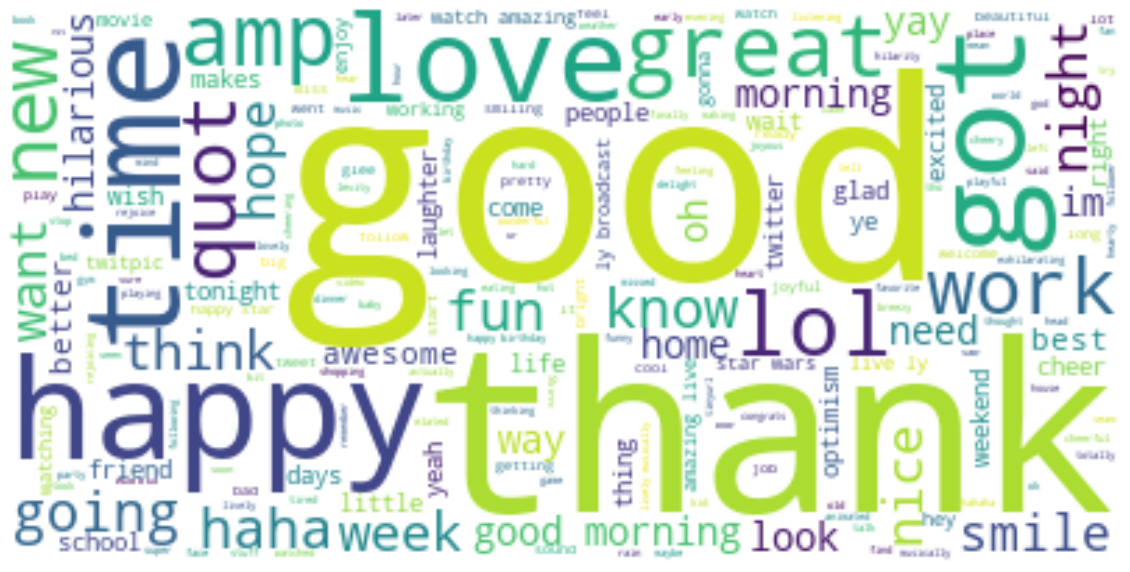

In [32]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="happiness", "lcased_text"].values, "Happiness Tweets")

Target Type :  Love Tweets


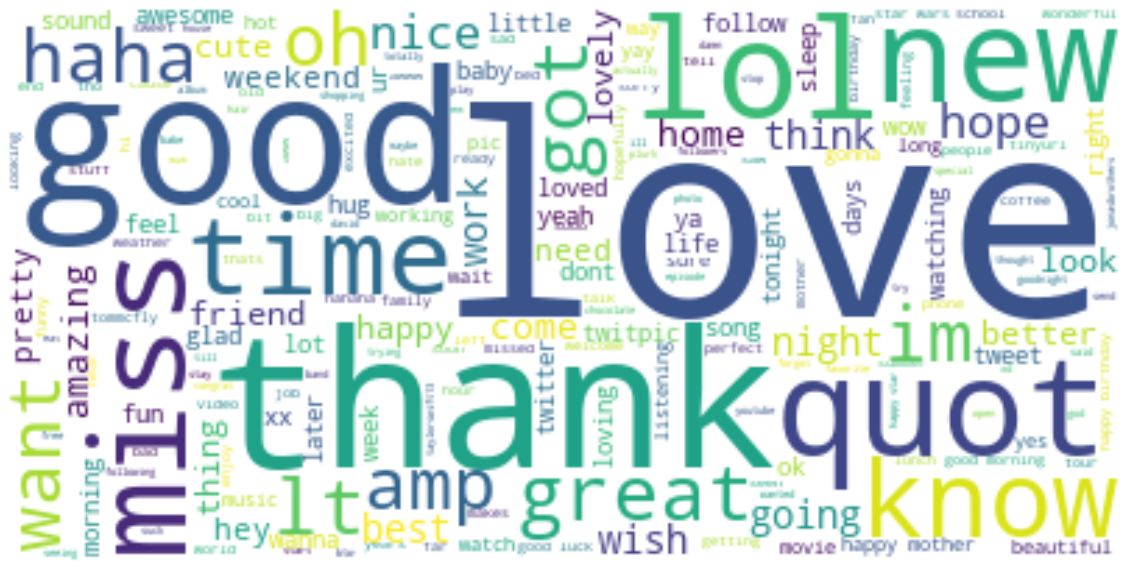

In [33]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="love", "lcased_text"].values, "Love Tweets")

Target Type :  Surprise Tweets


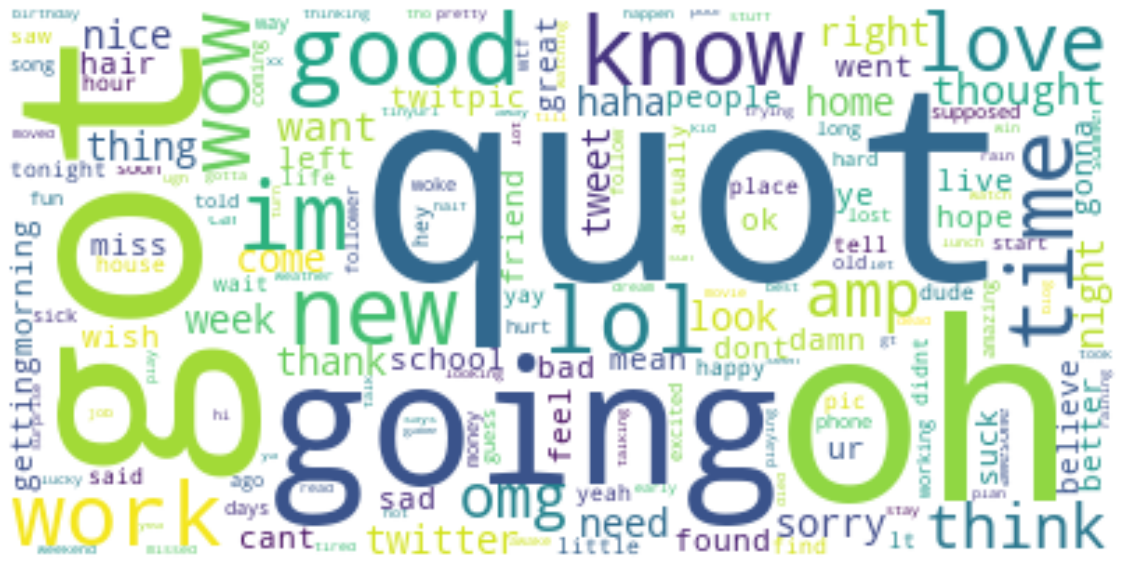

In [34]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="surprise", "lcased_text"].values, "Surprise Tweets")

Target Type :  Hate Tweets


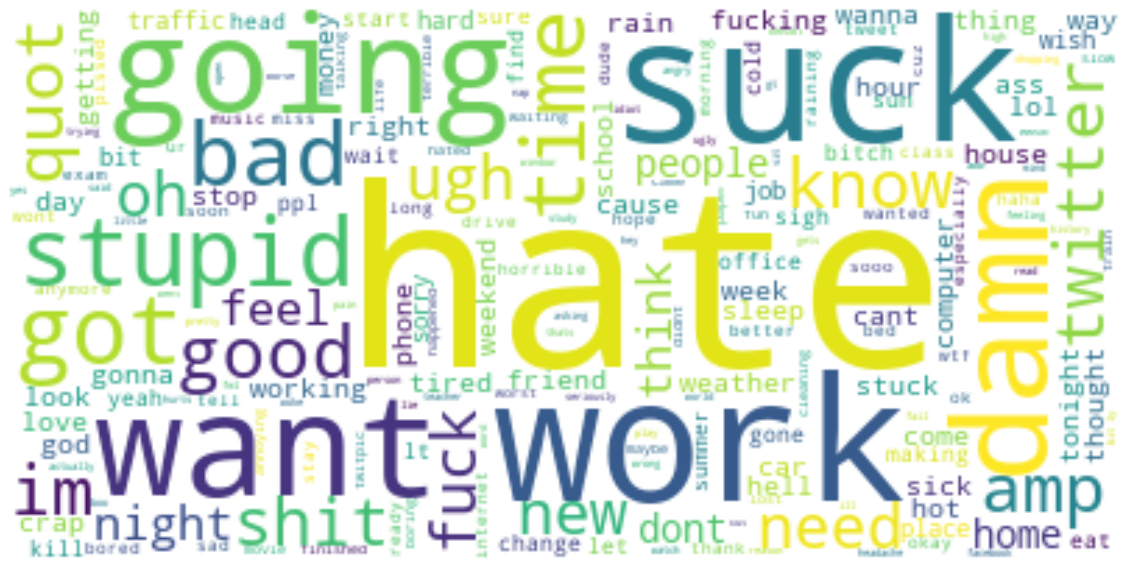

In [35]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="hate", "lcased_text"].values, "Hate Tweets")

Target Type :  Fun Tweets


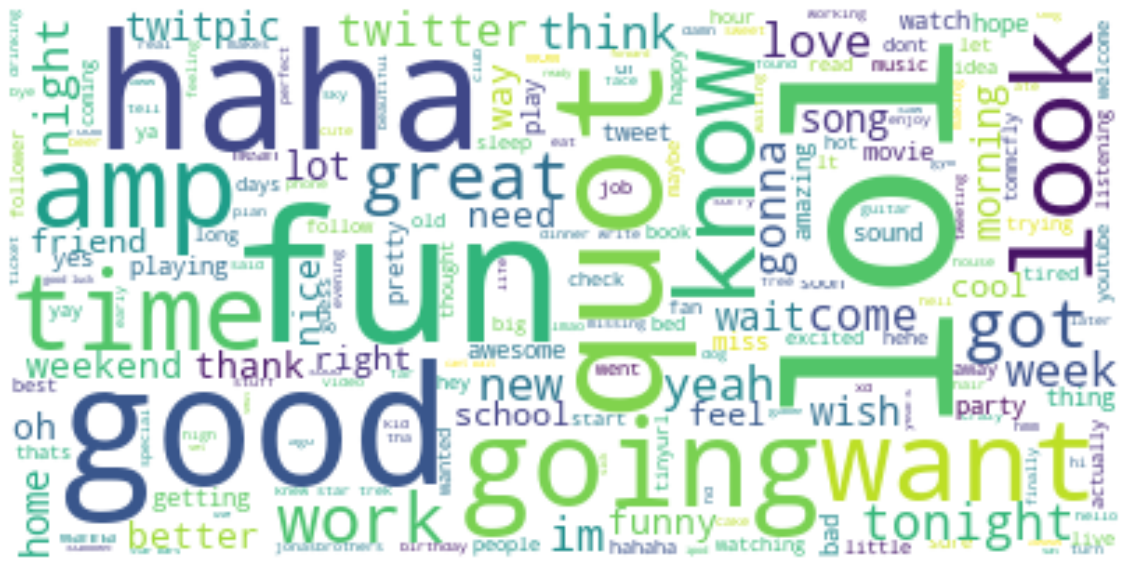

In [36]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="fun", "lcased_text"].values, "Fun Tweets")

Target Type :  Relief Tweets


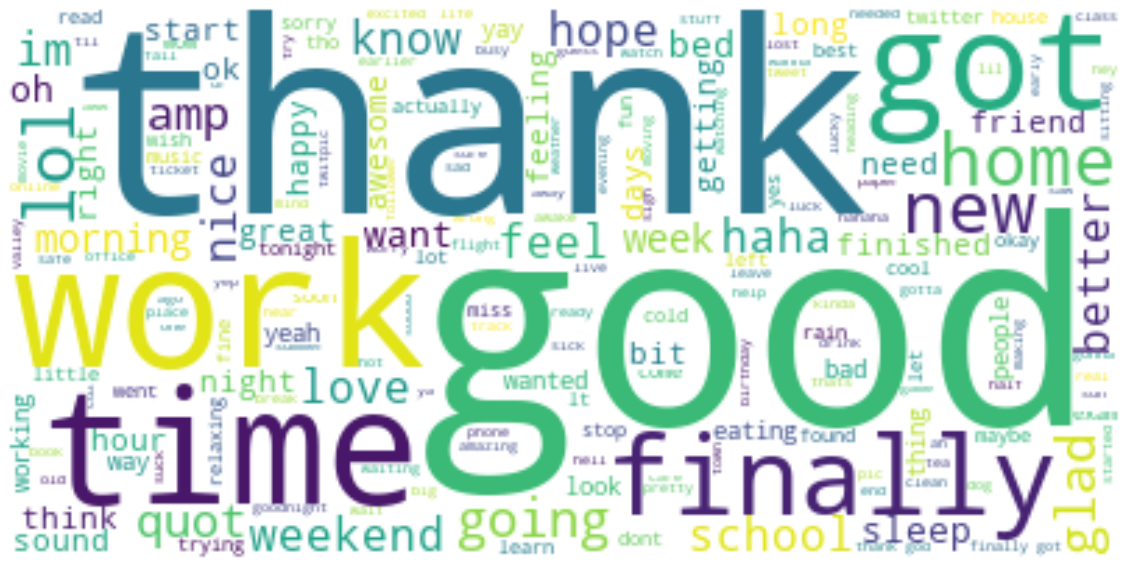

In [37]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="relief", "lcased_text"].values, "Relief Tweets")

Target Type :  Empty Tweets


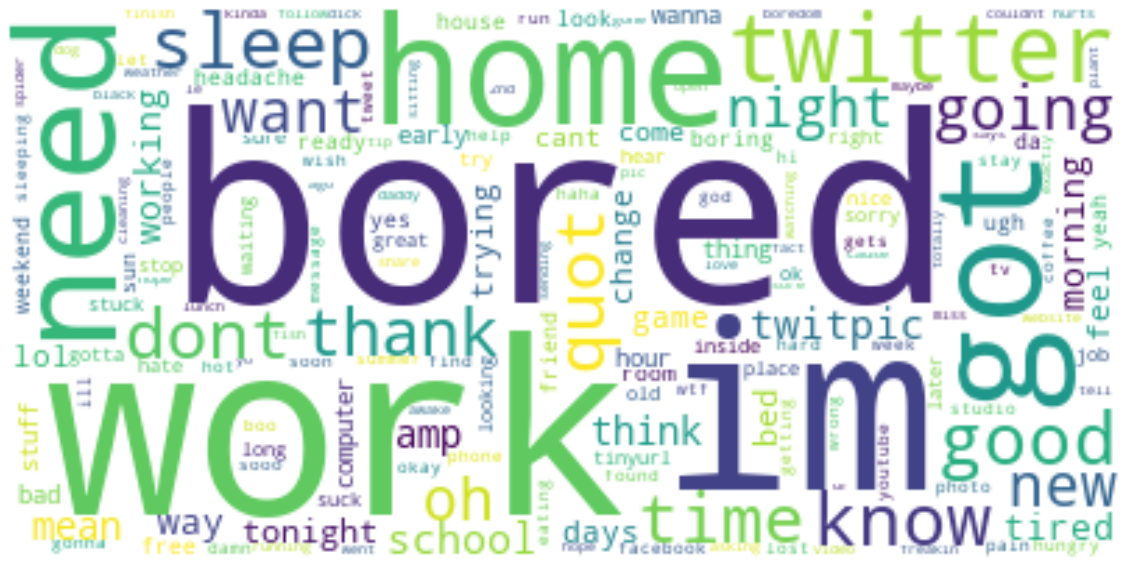

In [38]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="empty", "lcased_text"].values, "Empty Tweets")

Target Type :  Enthusiasm Tweets


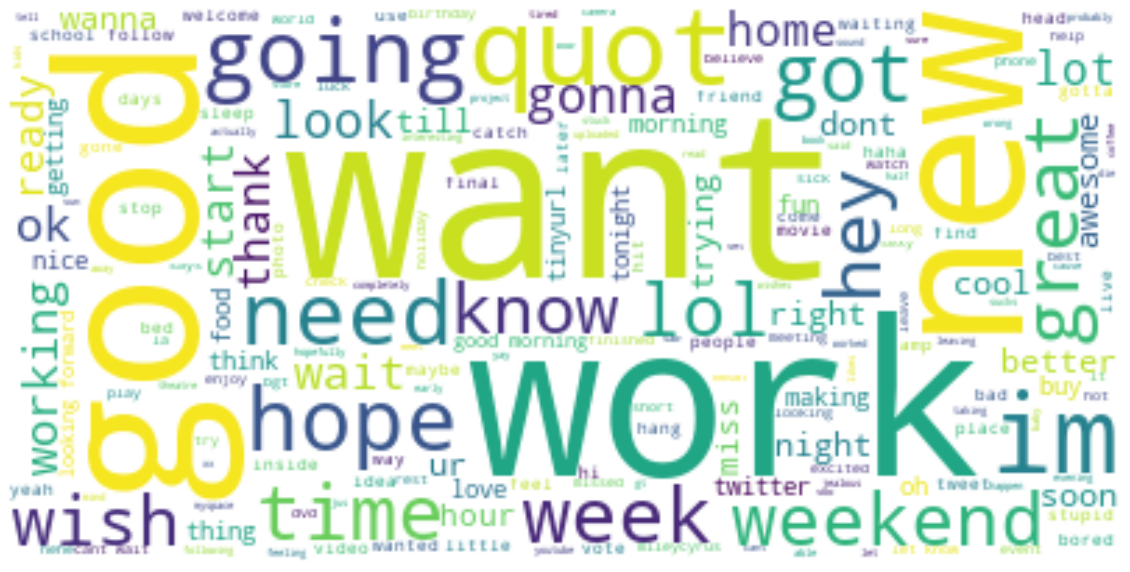

In [39]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="enthusiasm", "lcased_text"].values, "Enthusiasm Tweets")

Target Type :  Boredom Tweets


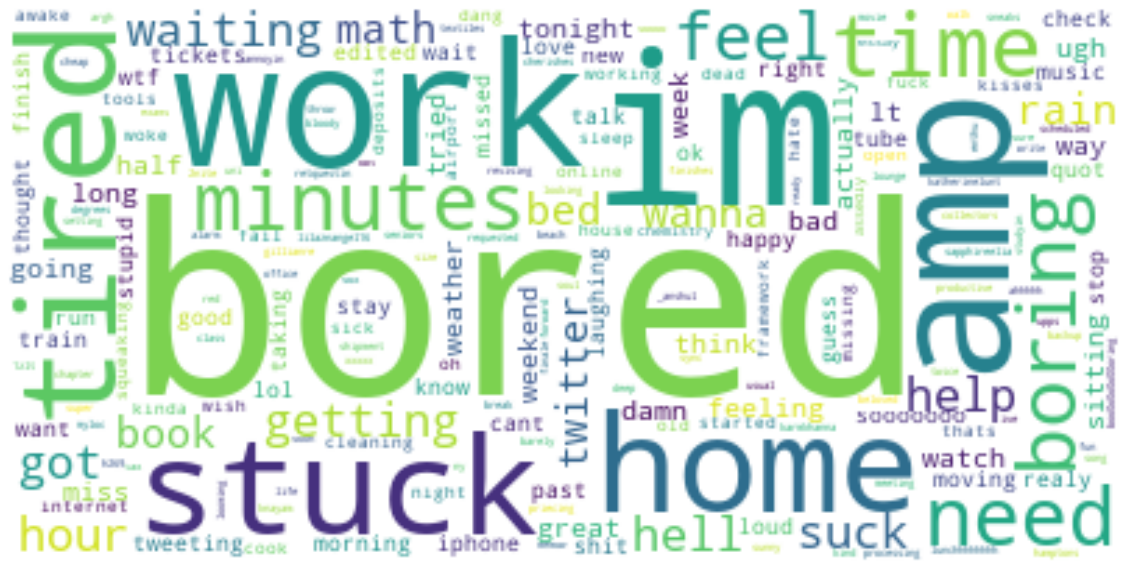

In [40]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="boredom", "lcased_text"].values, "Boredom Tweets")

Target Type :  Anger Tweets


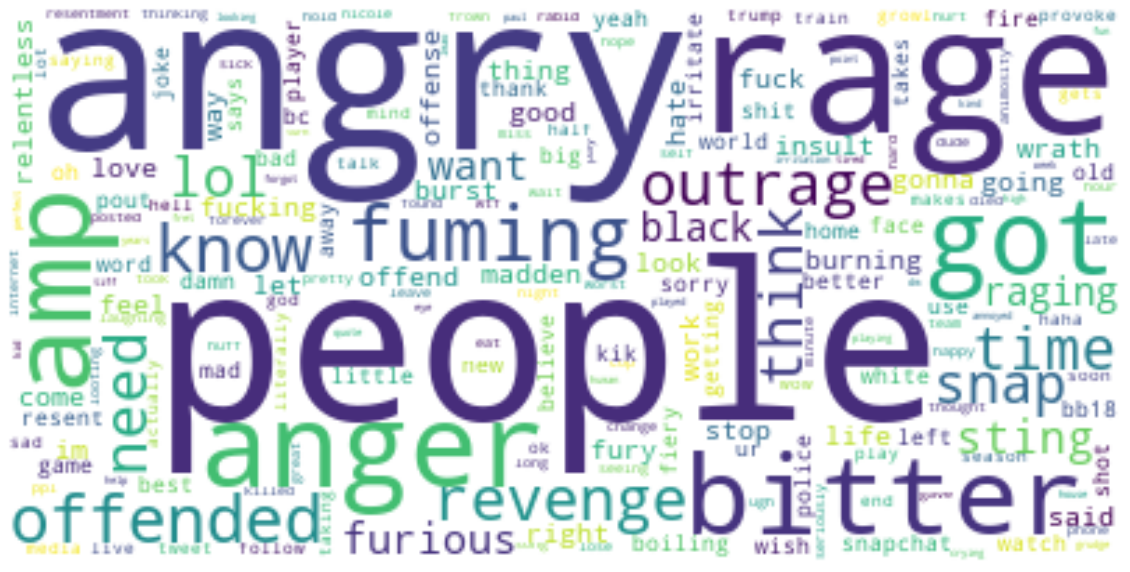

In [41]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="anger", "lcased_text"].values, "Anger Tweets")

Target Type :  Fear Tweets


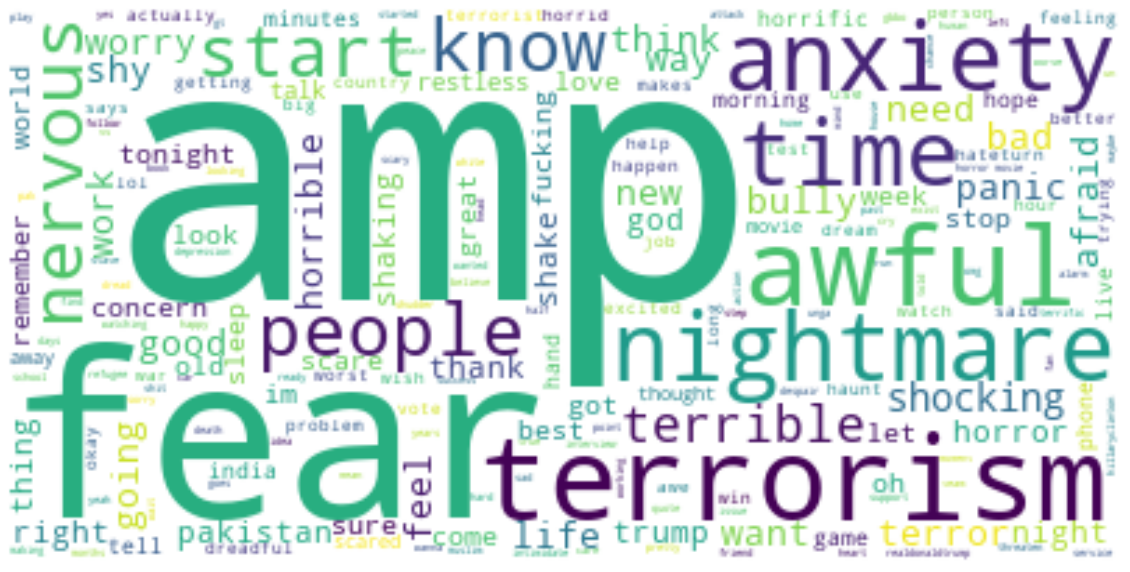

In [42]:
create_wordcloud(train_data.loc[train_data["sentiment"]=="fear", "lcased_text"].values, "Fear Tweets")